<a href="https://colab.research.google.com/github/Vernalhav/numeric_methods/blob/master/numerico_aplicacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Victor Giovannoni Vernalha 10786159  
Victor Graciano de Souza Correia 10431201

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# **Tema 1: Resolução de Sistemas Lineares**

## Revisão Teórica (TODO)

## Implementação

### Solução de sistemas por Cholesky

In [0]:
# Helper functions

def get_range(start, end):
    ''' Returns increasing np range if start < end, or decreasing if end < start '''
    if start <= end:
        return np.arange(start, end, 1)
    else:
        return np.arange(start, end, -1)


def check_triangular(A):
    ''' Checks if A is upper or lower triangular, or neither '''
    if np.allclose(A, np.tril(A)): return 'lower'
    if np.allclose(A, np.triu(A)): return 'upper'
    if np.allclose(A, np.diag(np.diag(A))): return 'diagonal'    
    return 'neither'

In [0]:
def cholesky(A, check_valid=True):
    '''
    Given a SPD matrix A, returns L, which is one of the
    cholesky factors of A.
    Throws ValueError if matrix is invalid
    '''
    
    A = np.array(A, float)

    L = np.zeros_like(A)
    n = A.shape[0]

    for j in range(n):
        for i in range(j, n):  # We want a lower triangular matrix
            if i == j:
                argument = A[i][j] - np.sum([np.square(L[i][k]) for k in range(j)])
                if (argument < 0):
                    raise ValueError("Non SPD matrix.")
                L[i][j] = np.sqrt(argument)
            else:
                if (L[j][j] == 0):
                    raise ValueError("Non SPD matrix.")
                L[i][j] = (1/L[j][j])*(A[i][j] - 
                           np.sum([L[i][k]*L[j][k] for k in range(j)]))
    
    return L

In [0]:
def substitution(T, b):
    '''
    Given T a triangular matrix,
    solves Tx = b. Returns x.
    Throws ValueError if matrix
    is invalid.
    '''

    n = T.shape[0]
    start, end = 0, n

    matrix_type = check_triangular(T)
    if matrix_type == 'upper':
        # Sets up indices for regressive substitution
        start, end = n - 1, -1
    if matrix_type == 'neither':
        raise ValueError('Matrix must be either upper or lower triangular')

    x = np.zeros((n, 1))
    for i in get_range(start, end):
        result = 0
        for j in get_range(start, i):
            result += T[i][j]*x[j]
        x[i] = (b[i] - result)/T[i][i]

    return x


def solve_linear_cholesky(A, b):
    '''
    Solves linear system of the form
    Ax = b where A is SPD. Returns
    array x.
    '''
    L = cholesky(A)
    y = substitution(L, b)
    x = substitution(L.T, y)
    assert np.allclose(np.dot(A, x), b) # Ensure results match with 10^-5 tolerance
    return x

### Solução de sistemas por Gauss-Seidel

In [0]:
# Helper function

def gauss_seidel_convergence(A):
    '''
    Returns boolean indicating whether or
    not Gauss-Seidel converges with A
    '''
    n = A.shape[0]
    beta = np.zeros((n, 1))
    beta[0] = np.sum(np.abs(A[0, 1:]))/np.abs(A[0, 0])
    if beta[0] >= 1: return False

    for i in range(1, n):
        # Since beta is initialized as 0, we can
        # do the dot product without worrying
        # about the row slice
        beta[i] = (np.dot(np.abs(A[i,:]), beta) +
                  np.sum(np.abs(A[i, i+1:])))/np.abs(A[i, i])
        if beta[i] >= 1: return False

    return True


In [0]:
EPSILON = 1e-6
MAX_ITERATIONS = 1000

def gauss_seidel(A, b, tol=EPSILON, max_iterations=MAX_ITERATIONS, return_errors=False):
    '''
    Given a real matrix A and an array b, solve for x
    iteratively until relative error < tol or number
    of iterations exceeds the max.
    '''
    A = np.array(A)
    n = A.shape[0]

    L_inv = np.linalg.inv(np.tril(A))
    R = np.triu(A, k=1)

    C = np.dot(-L_inv, R)
    g = np.dot(L_inv, b)

    x = np.zeros((n, 1))
    x_prev = np.zeros((n, 1))

    if not gauss_seidel_convergence(A): print('Warning: Gauss-Seidel might not converge for this matrix!')

    iterations = 0
    error = tol + 1 # Just to guarantee the first iteration
    errors = []

    while iterations < max_iterations and error > tol:
        x = np.dot(C, x_prev) + g
        
        iterations += 1
        error = absolute_error(x, x_prev)
        errors.append(error)
        x_prev = x
    
    if iterations == max_iterations: print('Method did not converge! (Error {})'.format(error))
    
    if return_errors: return x, errors
    return x

## Aplicação

# **Tema 2: Interpolação polinomial**

## Revisão teórica

O objetivo da interpolação polinomial é dado $n+1$ pontos $P_0, P_1, \dots P_n$, encontrar uma função polinomial $P(x)$ de grau $n$ que passe por todos os pontos dados.  
  
Optamos chegar nesse resultado através do polinômio no formato de Lagrange, já que a explicação é mais intuitiva e a implementação mais simples.  
  
Queremos encontrar um polinômio da forma $$P(x) = \sum_{k=0}^{n} y_kl_k(x)$$
Onde $l_k(x)$ é um polinômio que só depende da coordenada $x$ dos pontos dados e $y_k$ é a k-ésima coordenada $y$ dos pontos dados.  

Se o k-ésimo ponto tem coordenadas $(x_k, y_k)$, sabemos que $P(x_k) = y_k$, já que queremos que o polinômio passe por todos os pontos dados.  
Observe que uma maneira dessa condição ser atendida é para que todos os polinômios $\ l_i(x_k) = 0$ quando $i \neq k\ $ e $\ l_k(x_k) = 1$, já que o somatório iria resultar em exatamente $y_k$.  
Mas se $\ i \neq k \implies l_k(x_i) = 0$, então o conjunto $\{ x_0, \dots, x_{k-1}, x_{k+1}, \dots, x_n \}$ correspondem às raízes de $l_k(x)$.  
  
Podemos então escrever

$$ \quad l_k(x) = \alpha\prod_{\substack{i=0\\i \neq k}}^{n}(x - x_i) \tag{$\star$} $$

Observe que, de fato, o conjunto de raízes que definimos acima é satisfeito para esse polinômio. O fator $\alpha$ é necessário para representar todos os polinômios que possuem essas raízes. Para encontrar $\alpha$, basta utilizar o fato de que $l_k(x_k)=1$. Avaliando $l_k(x_k)$, temos:

$$1 = \alpha \prod_{\substack{i=0\\i \neq k}}^{n}(x_k-x_i),$$

logo

$$ \alpha = \prod_{\substack{i=0 \\ i \neq k}}^{n}(x_k - x_i)^{-1} $$
  
Portanto, substituindo $\alpha$ em $(\star)$, o nosso polinômio $l_k(x)$ é

$$l_k(x) = \prod_{\substack{i=0 \\ i \neq k}}^{n}\frac{(x - x_i)}{(x_k - x_i)}$$

  
Uma vez que definimos todos os $l_k(x)$, podemos construir $P(x)$.

## Implementação

In [0]:
def k_lagrange_polynomial(k, X):
    """
    Return the k-th lagrange polynomial as a function.
    It receives x as input and returns L_k(x)
    """
    x_k = X[k]
    X_new = np.delete(X, k)

    def k_polynomial(x):
        return np.prod((x - X_new)/(x_k - X_new))
    
    return k_polynomial

In [0]:
def lagrange_polynomial(X, Y, return_Ls=False):
    """
    Returns the polynomial that fits the given points X/Y
    as a function.
    The returned function receives x as input and returns
    P(x).

    If retuen_Ls is True, then this function returns a tuple
    with the first element being P(x) and the second is an
    array with all the L_k polynomials used to compute P(x).
    """

    X = np.array(X)
    Y = np.array(Y)
    n = X.shape[0]
    
    L = [ k_lagrange_polynomial(k, X) for k in range(n) ]

    def polynomial(x):
        L_x = np.array([ L[k](x) for k in range(n) ])
        return np.dot(Y, L_x)

    if return_Ls: return polynomial, L
    
    return polynomial

## Aplicação: aproximação de funções por _sampling_

In [0]:
def approximate(points, x_0, show_Ls=True, show_axis=False):
    """
    Approximate a value P(x_0) given a set of points by
    fitting a polynomial through them. 
    
    Returns P(x_0), where P(x) is the lagrange polynomial
    that fits the given points and displays the computed
    polynomial.

    If show_Ls is false, do not display the L polynomials
    that were used to compute P(x). If it is true, display
    y_k*l_k(x)

    If show_axis is true, display the x axis.
    """

    X = [points[i][0] for i in range(len(points))]
    Y = [points[i][1] for i in range(len(points))]

    P, L = lagrange_polynomial(X, Y, return_Ls=True)
    
    min_x = min(X)
    max_x = max(X)

    avg_x_dist = (min_x + max_x + 1)/(2*len(X))

    # x coordinates to evaluate P(x) in
    x = np.linspace(min(x_0, min_x) - avg_x_dist, max(x_0, max(X)) + avg_x_dist, 10*len(X))

    plt.plot(x, [P(x_i) for x_i in x])  # Plot P(x)
    plt.scatter(X, Y, marker='o')       # Mark given points

    plt.scatter(x_0, P(x_0), marker='o', color='red')   # Mark x_0/P(x_0)

    if show_axis: plt.plot([x[0], x[-1]], [0, 0], color='black') # Plot x axis

    if not show_Ls:
        plt.show()
        return P(x_0)

    for i in range(len(L)):
        # Plot y_i*L_k(x)
        plt.plot(x, [Y[i]*L[i](x_i) for x_i in x], linestyle='--', alpha=0.7)

    plt.show()
    return P(x_0)

Algo interessante de se visualizar é que o polinômio $y_kl_k(x)$ gerado por cada $x_k$ se intersecta com a curva final no ponto $(x_k, y_k)$ por conta da restrição que impusemos:  $l_k(x_k) = 1$. Além disso, o polinômio é 0 para os outros pontos fornecidos por conta da outra restrição que impusemos com relação às suas raízes.

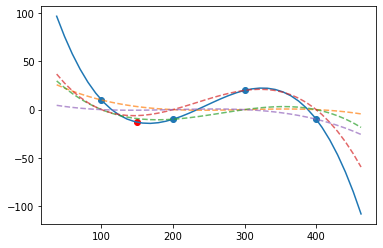

An approximation for f(150) is -13.12


In [0]:
points = [(100, 10), (200, -10), (300, 20), (400, -10)]
x_0 = 150

approx = approximate(points, x_0)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

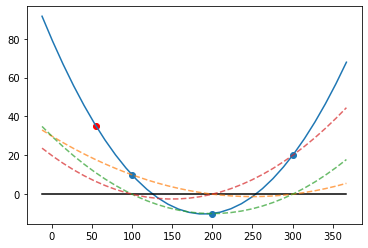

An approximation for f(55) is 35.31


In [0]:
x_0 = 55
points = [(100, 10), (200, -10), (300, 20)]

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

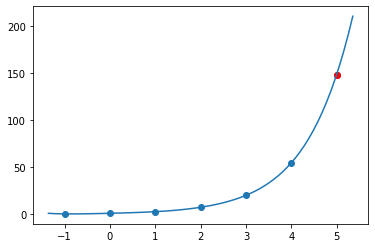

An approximation for f(5) is 148.41


In [0]:
points = [(x, np.exp(x)) for x in range(-1, 6)]
x_0 = 5

approx = approximate(points, x_0, show_axis=False, show_Ls=False)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

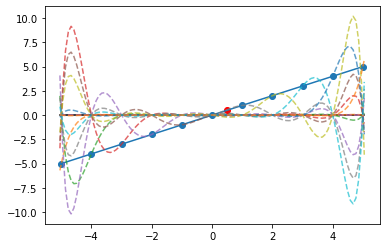

An approximation for f(0.5) is 0.50


In [0]:
points = [(x, x) for x in range(-5, 6)]
x_0 = 0.5

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

# **Tema 3: Regressão Linear**

## Revisão Teórica (TODO)

## Implementação

## Aplicação

# **Tema 4: Solução Numérica de EDOs ou Autovalores**

## Revisão Teórica (TODO)

## Implementação

## Aplicação